In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [51]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets, split at 90%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 1)

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.046917621385706494
Percent Type II errors: 0.17648663393344244

Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.17668711656441718


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

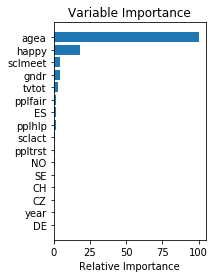

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

### Tune hyperparameters using AUC to measure model performance

In [5]:
from sklearn.metrics import roc_curve, auc

# Tune n_estimators

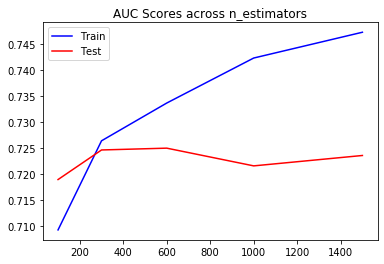

In [6]:
estimators = [100,300,600,1000,1500]

train_results = []
test_results = []

for n in estimators:

    #Set params
    
    params = {'n_estimators': n,
              'max_depth': 2,
              'loss': 'deviance'}

    # Initialize and fit the model.
    
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # Get predictions from train data, compute auc score, append to train_results
    
    train_pred = clf.predict(X_train)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_train, train_pred)
    train_auc = auc(false_pos_rate, true_pos_rate)
    train_results.append(train_auc)
    
    # Get predictions from train data, compute auc score, append to train_results
    
    test_pred = clf.predict(X_test)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, test_pred)
    test_auc = auc(false_pos_rate, true_pos_rate)   
    test_results.append(test_auc)
    
plt.plot(estimators, train_results, 'b', label='Train')
plt.plot(estimators, test_results, 'r', label='Test')
plt.legend(('Train', 'Test'))
plt.title('AUC Scores across n_estimators')
plt.show()

The model performed best at 300-600 estimators in the test set, to reduce the computation time let's set n_estimators at 300.

# Tune max_depth

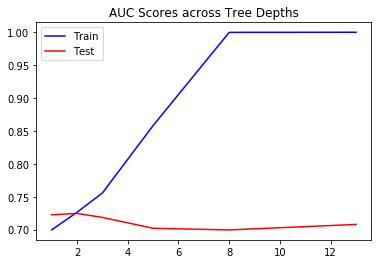

In [7]:
depths = [1,2,3,5,8,13]

train_results = []
test_results = []

for depth in depths:

    #Set params
    
    params = {'n_estimators': 300,
              'max_depth': depth,
              'loss': 'deviance'}

    # Initialize and fit the model.
    
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # Get predictions from train data, compute auc score, append to train_results
    
    train_pred = clf.predict(X_train)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_train, train_pred)
    train_auc = auc(false_pos_rate, true_pos_rate)
    train_results.append(train_auc)
    
    # Get predictions from train data, compute auc score, append to train_results
    
    test_pred = clf.predict(X_test)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, test_pred)
    test_auc = auc(false_pos_rate, true_pos_rate)   
    test_results.append(test_auc)
    
plt.plot(depths, train_results, 'b', label='Train')
plt.plot(depths, test_results, 'r', label='Test')
plt.legend(('Train', 'Test'))
plt.title('AUC Scores across Tree Depths')
plt.show()

We will keep the max_depth set to 2.

# Tune learning_rate

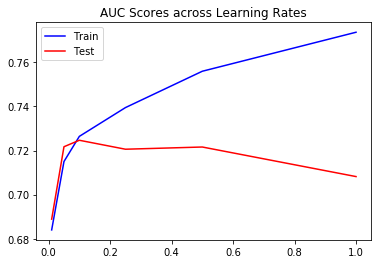

In [8]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []

for learning_rate in learning_rates:

    #Set params
    
    params = {'n_estimators': 300,
              'max_depth': 2,
              'loss': 'deviance',
             'learning_rate':learning_rate}

    # Initialize and fit the model.
    
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # Get predictions from train data, compute auc score, append to train_results
    
    train_pred = clf.predict(X_train)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_train, train_pred)
    train_auc = auc(false_pos_rate, true_pos_rate)
    train_results.append(train_auc)
    
    # Get predictions from train data, compute auc score, append to train_results
    
    test_pred = clf.predict(X_test)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, test_pred)
    test_auc = auc(false_pos_rate, true_pos_rate)   
    test_results.append(test_auc)
    
plt.plot(learning_rates, train_results, 'b', label='Train')
plt.plot(learning_rates, test_results, 'r', label='Test')
plt.legend(('Train', 'Test'))
plt.title('AUC Scores across Learning Rates')
plt.show()

It looks like the default value of 0.1 was the best learning rate for the model.

# Tune min_samples_split

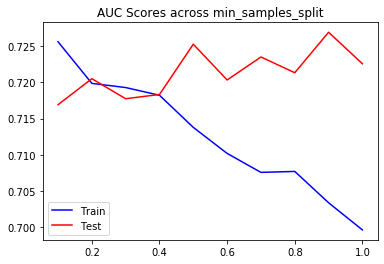

In [9]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results = []

for split in min_samples_splits:

    #Set params
    
    params = {'n_estimators': 300,
              'max_depth': 2,
              'loss': 'deviance',
             'min_samples_split': split}

    # Initialize and fit the model.
    
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # Get predictions from train data, compute auc score, append to train_results
    
    train_pred = clf.predict(X_train)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_train, train_pred)
    train_auc = auc(false_pos_rate, true_pos_rate)
    train_results.append(train_auc)
    
    # Get predictions from train data, compute auc score, append to train_results
    
    test_pred = clf.predict(X_test)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, test_pred)
    test_auc = auc(false_pos_rate, true_pos_rate)   
    test_results.append(test_auc)
    
plt.plot(min_samples_splits, train_results, 'b', label='Train')
plt.plot(min_samples_splits, test_results, 'r', label='Test')
plt.legend(('Train', 'Test'))
plt.title('AUC Scores across min_samples_split')
plt.show()

Our model performed best at a sample of 90% (0.9) for the min_samples_split paramater, the default for this value is 100% (1)

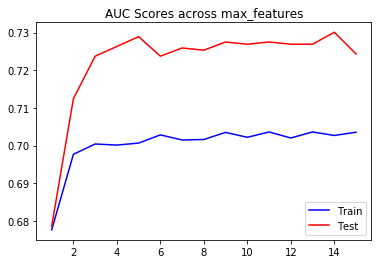

In [10]:
max_features = list(range(1,X_train.shape[1]))

train_results = []
test_results = []

for n in max_features:

    #Set params
    
    params = {'n_estimators': 300,
              'max_depth': 2,
              'loss': 'deviance',
             'min_samples_split': 0.9,
             'max_features': n}

    # Initialize and fit the model.
    
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # Get predictions from train data, compute auc score, append to train_results
    
    train_pred = clf.predict(X_train)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_train, train_pred)
    train_auc = auc(false_pos_rate, true_pos_rate)
    train_results.append(train_auc)
    
    # Get predictions from train data, compute auc score, append to train_results
    
    test_pred = clf.predict(X_test)    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, test_pred)
    test_auc = auc(false_pos_rate, true_pos_rate)   
    test_results.append(test_auc)
    
plt.plot(max_features, train_results, 'b', label='Train')
plt.plot(max_features, test_results, 'r', label='Test')
plt.legend(('Train', 'Test'))
plt.title('AUC Scores across max_features')
plt.show()

Our model performs best with a max of 14 features considered at each split. Let's put our tuned model to the test against the original model.

In [18]:
# We'll make 300 iterations, use 2-deep trees, and set our min_samples_split to 0.9, and max_features to 14

params = {'n_estimators': 300,
          'max_depth': 2,
          'loss': 'deviance',
         'min_samples_split': 0.9,
         'max_features': 14}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0463720676486634
Percent Type II errors: 0.19899072558647027

Test set accuracy:
Percent Type I errors: 0.04171779141104295
Percent Type II errors: 0.18773006134969325


While we were able to slightly reduce our Type I percentage, we increased our Type II error percentages for both the training and test sets. On a positive note, the model shows no signs of overfitting. These findings suggest that an additional feature is needed by the model to reduce the Type II errors (false negatives) as there are some characteristics in these false negatives that is not being identified by the current features.

# Create interactions by gender

In [67]:
# Create features that may have interactions with gender

var_list = ['tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet', 'sclact']

for var in var_list:
    varname = str(var + '_by_gender')
    df[varname] = df[var] * (df['gndr']-1)
    
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets, split at 90%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 1)

In [68]:
# We'll make 300 iterations, use 2-deep trees, and set our min_samples_split to 0.9, and max_features to 14

params = {'n_estimators': 300,
          'max_depth': 2,
          'loss': 'deviance',
         'min_samples_split': 0.9,
         'max_features': 14}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.19858156028368795

Test set accuracy:
Percent Type I errors: 0.044171779141104296
Percent Type II errors: 0.18773006134969325


## Conclusion

Once again, we continued to demonstrate a low Type I error. However, the Type II error continues to be mostly unchanged. This continues to show that our model does a good job of avoiding false positives, but it is failing to identify about 19% of the partners in the data. A feature needs to be added to the model which allows it to identify those 19% that are being missed.